In [ ]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(tidyverse)
library(magrittr)
library(SeuratWrappers)
library(glue)
library(data.table)
library(ggsci)
library(patchwork)

## 批次校正相关包
library(harmony)       # Harmony
library(batchelor)     # FastMNN
library(rliger)        # LIGER (iNMF)
library(conos)         # Conos
library(sva)           # ComBat
library(STACAS)        # STACAS
library(sceasy)        # R <-> Python h5ad 转换

Loading required package: SeuratObject

Loading required package: sp




Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.6.0
✔ lubridate 1.9.4     ✔ tibble    3.3.0
✔ purrr     1.1.0     ✔ tidyr     1.3.1
✔ readr     2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘data.table’


In [ ]:
seu = qs::qread("/home/data/tanglei/project/prostate_altas/output/06/Sketch_Integration.qs")

In [ ]:
## 先筛出 sketch 细胞，再做去批次
DefaultAssay(seu) <- "sketch"

# 优先使用 PCA 中实际参与 sketch 分析的细胞
if ("pca" %in% Reductions(seu)) {
  sketch.cells <- Cells(seu[["pca"]])
} else {
  sketch.cells <- colnames(seu[["sketch"]])
}

seu <- subset(seu, cells = sketch.cells)

dim(seu)

[1]  38606 233430

In [ ]:
#### ========== 关键参数设定 ========== ####
batch_var   <- "GSE.ID"   # <-- 手动修改批次变量（可选 "orig.ident" / "GSE.ID" 或 metadata 中的任意列）
celltype_var <- "celltype"     # <-- 细胞类型列名，scANVI 需要
n_hvg       <- 3000            # HVG 数量
n_pcs       <- 50              # PCA 维度
n_dims      <- 1:n_pcs         # 下游统一使用 50 维用于 benchmark

output_dir <- "/home/data/tanglei/project/prostate_altas/output/06"

## !! 661k 细胞数据量大，必须解除 future 全局变量大小限制
## 否则 IntegrateLayers (CCA/RPCA 等) 会报 future.globals.maxSize 错误
options(future.globals.maxSize = Inf)

cat("批次变量:", batch_var, "\n")
cat("细胞数:", ncol(seu), "\n")
cat("批次数:", length(unique(seu[[batch_var, drop = TRUE]])), "\n")

批次变量: GSE.ID 


细胞数: 233430 
批次数: 12 


Splitting ‘counts’, ‘data’ layers. Not splitting ‘scale.data’. If you would like to split other layers, set in `layers` argument.

Warning message:
“Different features in new layer data than already exists for scale.data”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


预处理完成。PCA dims: 50 


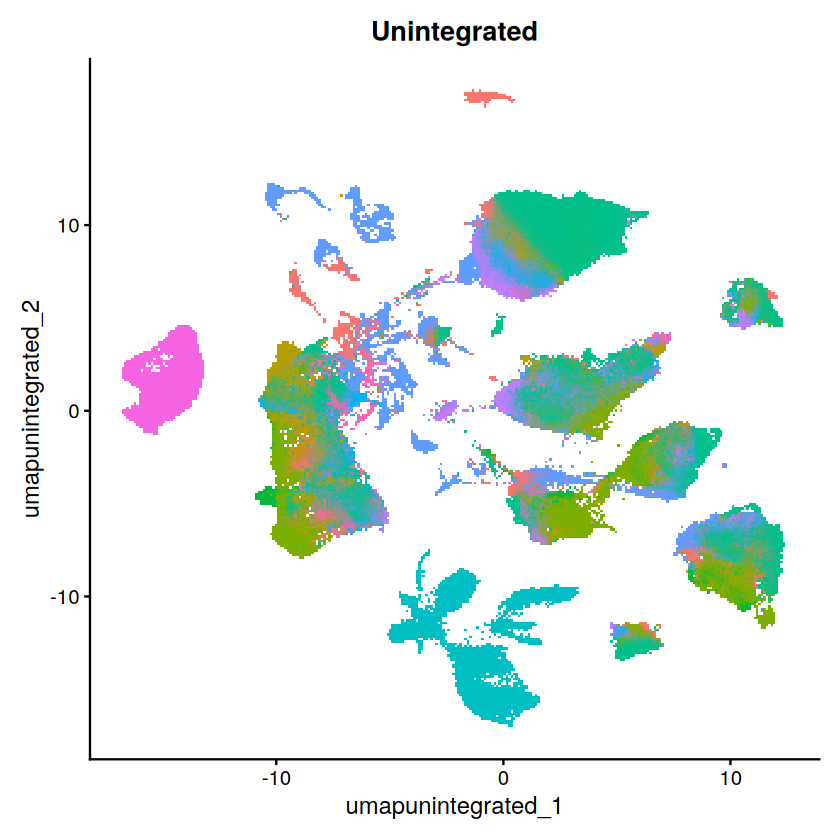

In [ ]:
#### ========== Part 1: 公共预处理 ========== ####
## Seurat v5: split layers -> Normalize -> HVG -> Scale -> PCA

# 按批次拆分 layer（IntegrateLayers 要求）
batch_vec <- seu[[batch_var, drop = TRUE]]
if (is.null(batch_vec)) stop(paste0("metadata 中不存在批次列: ", batch_var))
batch_vec <- as.character(batch_vec)
names(batch_vec) <- colnames(seu)
if (anyNA(batch_vec)) stop(paste0("批次列含 NA，请先处理: ", batch_var))

# 如果之前已经 split 过，先 Join 再按当前 batch 重新 split
layer_names <- Layers(seu[["sketch"]])
already_split <- any(grepl("^(counts|data)\\.[0-9]+$", layer_names))
if (already_split) {
  seu[["sketch"]] <- JoinLayers(seu[["sketch"]])
}
seu[["sketch"]] <- split(seu[["sketch"]], f = batch_vec)

seu <- NormalizeData(seu, verbose = FALSE)
seu <- FindVariableFeatures(seu, nfeatures = n_hvg, verbose = FALSE)
seu <- ScaleData(seu, verbose = FALSE)
seu <- RunPCA(seu, npcs = n_pcs, verbose = FALSE)

# 未校正 PCA 的 UMAP（作为 baseline）
seu <- RunUMAP(seu, reduction = "pca", dims = n_dims,
               reduction.name = "umap.unintegrated", verbose = FALSE)

cat("预处理完成。PCA dims:", ncol(Embeddings(seu, "pca")), "\n")
DimPlot(seu, reduction = "umap.unintegrated", group.by = batch_var,
        raster = TRUE, raster.dpi = c(300, 300)) +
  ggtitle("Unintegrated") + NoLegend()


In [ ]:
#### ========== Part 2a: CCA 整合 ========== ####
## 注意：CCA 在大数据集（>100k 细胞）上非常耗时，如需跳过可注释本 cell
cat(">>> CCA Integration 开始...\n")
t_cca <- system.time({
  seu <- IntegrateLayers(
    object = seu,
    method = CCAIntegration,
    orig.reduction = "pca",
    new.reduction = "cca",
    verbose = FALSE
  )
})
cat("CCA 耗时:", t_cca["elapsed"], "秒\n")

qs::qsave(seu, "/home/data/tanglei/project/prostate_altas/output/06/Sketch_Integration.qs")

>>> CCA Integration 开始...


Warning message:
“Adding a dimensional reduction (cca) without the associated assay being present”


CCA 耗时: 6120.536 秒


In [ ]:
#### ========== Part 2b: RPCA 整合 ========== ####
cat(">>> RPCA Integration 开始...\n")
t_rpca <- system.time({
  seu <- IntegrateLayers(
    object = seu,
    method = RPCAIntegration,
    orig.reduction = "pca",
    new.reduction = "rpca",
    verbose = FALSE
  )
})
cat("RPCA 耗时:", t_rpca["elapsed"], "秒\n")

qs::qsave(seu, "/home/data/tanglei/project/prostate_altas/output/06/Sketch_Integration.qs")

>>> RPCA Integration 开始...


Warning message:
“Adding a dimensional reduction (rpca) without the associated assay being present”


RPCA 耗时: 4048.522 秒


In [ ]:
#### ========== Part 2c: Harmony 整合 ========== ####
cat(">>> Harmony Integration 开始...\n")
t_harmony <- system.time({
  seu <- IntegrateLayers(
    object = seu,
    method = HarmonyIntegration,
    orig.reduction = "pca",
    new.reduction = "harmony",
    verbose = FALSE
  )
})
cat("Harmony 耗时:", t_harmony["elapsed"], "秒\n")

qs::qsave(seu, "/home/data/tanglei/project/prostate_altas/output/06/Sketch_Integration.qs")

>>> Harmony Integration 开始...


The `features` argument is ignored by `HarmonyIntegration`.
This message is displayed once per session.
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 11671500)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 11671500)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 11671500)”


Harmony 耗时: 866.584 秒


In [ ]:
#### ========== Part 2d: FastMNN (MNN) 整合 ========== ####
cat(">>> FastMNN Integration 开始...\n")
t_mnn <- system.time({
  seu <- IntegrateLayers(
    object = seu,
    method = FastMNNIntegration,
    orig.reduction = "pca",
    new.reduction = "mnn",
    verbose = FALSE
  )
})
cat("FastMNN 耗时:", t_mnn["elapsed"], "秒\n")
DefaultAssay(seu[["mnn"]]) <- "sketch"

qs::qsave(seu, "/home/data/tanglei/project/prostate_altas/output/06/Sketch_Integration.qs")

>>> FastMNN Integration 开始...


Warning message:
“Adding a dimensional reduction (mnn) without the associated assay being present”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


FastMNN 耗时: 1458.729 秒


In [ ]:
#### ========== Part 3: LIGER (iNMF) 整合 ========== ####
## rliger v2 workflow: 从 Seurat 提取 counts -> 构建 liger 对象 -> iNMF -> 存回 Seurat
cat(">>> LIGER Integration 开始...\n")

## 先 JoinLayers 以获取完整 counts 矩阵
seu_tmp <- JoinLayers(seu)

t_liger <- system.time({
  ## 提取 counts 和 batch 信息
  counts_mat <- GetAssayData(seu_tmp, assay = "sketch", layer = "counts")
  batch_labels <- seu_tmp[[batch_var, drop = TRUE]]
  
  ## 按 batch 拆分 counts 为 list
  batches <- unique(batch_labels)
  raw_data_list <- lapply(setNames(batches, batches), function(b) {
    idx <- which(batch_labels == b)
    counts_mat[, idx, drop = FALSE]
  })
  
  ## 创建 liger 对象
  liger_obj <- createLiger(raw_data_list)
  
  ## 标准 LIGER 流程
  liger_obj <- rliger::normalize(liger_obj)
  liger_obj <- selectGenes(liger_obj, var.thresh = 0.1)
  liger_obj <- scaleNotCenter(liger_obj)
  
  ## 运行 iNMF（online iNMF 适用于大数据集）
  k_val <- 50
  liger_obj <- runIntegration(liger_obj, k = k_val, method = "iNMF")
  liger_obj <- quantileNorm(liger_obj)
  
  ## 提取 H 矩阵（cell embedding）
  H_norm <- getMatrix(liger_obj, "H.norm")
  H_norm <- as.matrix(H_norm)

  ## 对齐 cell 顺序（兼容 rliger 自动添加 batch 前缀）
  cells_seu <- colnames(seu)
  batches_chr <- as.character(batches)

  strip_batch_prefix <- function(x, batch_names) {
    out <- as.character(x)
    for (b in batch_names) {
      pref <- paste0(b, "_")
      hit <- startsWith(out, pref)
      out[hit] <- substring(out[hit], nchar(pref) + 1L)
    }
    out
  }

  if (!is.null(rownames(H_norm)) && all(cells_seu %in% rownames(H_norm))) {
    H_norm <- H_norm[cells_seu, , drop = FALSE]
  } else if (!is.null(colnames(H_norm)) && all(cells_seu %in% colnames(H_norm))) {
    ## 如果 cells 在列，转置成 cells x factors
    H_norm <- t(H_norm[, cells_seu, drop = FALSE])
  } else if (!is.null(rownames(H_norm)) && all(cells_seu %in% strip_batch_prefix(rownames(H_norm), batches_chr))) {
    rn_norm <- strip_batch_prefix(rownames(H_norm), batches_chr)
    idx <- match(cells_seu, rn_norm)
    H_norm <- H_norm[idx, , drop = FALSE]
    rownames(H_norm) <- cells_seu
  } else if (!is.null(colnames(H_norm)) && all(cells_seu %in% strip_batch_prefix(colnames(H_norm), batches_chr))) {
    cn_norm <- strip_batch_prefix(colnames(H_norm), batches_chr)
    idx <- match(cells_seu, cn_norm)
    H_norm <- t(H_norm[, idx, drop = FALSE])
    rownames(H_norm) <- cells_seu
  } else {
    ## 名字仍无法匹配时，按构建 raw_data_list 时的顺序重建映射
    cells_by_batch <- unlist(lapply(batches_chr, function(b) {
      colnames(counts_mat)[which(batch_labels == b)]
    }), use.names = FALSE)

    if (nrow(H_norm) == length(cells_by_batch)) {
      rownames(H_norm) <- cells_by_batch
      H_norm <- H_norm[cells_seu, , drop = FALSE]
    } else if (ncol(H_norm) == length(cells_by_batch)) {
      H_norm <- t(H_norm)
      rownames(H_norm) <- cells_by_batch
      H_norm <- H_norm[cells_seu, , drop = FALSE]
    } else {
      common_r <- if (is.null(rownames(H_norm))) NA_integer_ else length(intersect(cells_seu, rownames(H_norm)))
      common_c <- if (is.null(colnames(H_norm))) NA_integer_ else length(intersect(cells_seu, colnames(H_norm)))
      common_r_strip <- if (is.null(rownames(H_norm))) NA_integer_ else length(intersect(cells_seu, strip_batch_prefix(rownames(H_norm), batches_chr)))
      common_c_strip <- if (is.null(colnames(H_norm))) NA_integer_ else length(intersect(cells_seu, strip_batch_prefix(colnames(H_norm), batches_chr)))
      stop(paste0(
        "H.norm 无法与 Seurat 细胞名对齐。\n",
        "- Seurat cells: ", length(cells_seu), "\n",
        "- H.norm dim: ", paste(dim(H_norm), collapse = " x "), "\n",
        "- H.norm rownames: ", if (is.null(rownames(H_norm))) "NULL" else "present", " (common=", common_r, ", strip_common=", common_r_strip, ")\n",
        "- H.norm colnames: ", if (is.null(colnames(H_norm))) "NULL" else "present", " (common=", common_c, ", strip_common=", common_c_strip, ")\n"
      ))
    }
  }

  colnames(H_norm) <- paste0("liger_", seq_len(ncol(H_norm)))
})

## 存入 Seurat
seu[["liger"]] <- CreateDimReducObject(
  embeddings = as.matrix(H_norm),
  key = "liger_",
  assay = DefaultAssay(seu)
)
cat("LIGER 耗时:", t_liger["elapsed"], "秒\n")

## 清理
rm(seu_tmp, counts_mat, batch_labels, batches, raw_data_list, liger_obj, H_norm)
gc()

qs::qsave(seu, "/home/data/tanglei/project/prostate_altas/output/06/Sketch_Integration.qs")



>>> LIGER Integration 开始...


ℹ calculating QC for dataset "GSE137829"

ℹ Updated QC variables: "nUMI", "nGene", "mito", "ribo", and "hemo"

ℹ calculating QC for dataset "GSE137829"
✔ calculating QC for dataset "GSE137829" ... done



ℹ calculating QC for dataset "GSE157703"

ℹ Updated QC variables: "nUMI", "nGene", "mito", "ribo", and "hemo"

ℹ calculating QC for dataset "GSE157703"
✔ calculating QC for dataset "GSE157703" ... done



ℹ calculating QC for dataset "GSE166782"

ℹ Updated QC variables: "nUMI", "nGene", "mito", "ribo", and "hemo"

ℹ calculating QC for dataset "GSE166782"
✔ calculating QC for dataset "GSE166782" ... done



ℹ calculating QC for dataset "GSE172357"

ℹ Updated QC variables: "nUMI", "nGene", "mito", "ribo", and "hemo"

ℹ calculating QC for dataset "GSE172357"
✔ calculating QC for dataset "GSE172357" ... done



ℹ calculating QC for dataset "GSE179615"

ℹ Updated QC variables: "nUMI", "nGene", "mito", "ribo", and "hemo"

ℹ calculating QC for dataset "GSE179615"
✔ calculating QC for dataset

LIGER 耗时: 11054.56 秒


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,12153004,649.1,19462924,1039.5,19462924,1039.5
Vcells,4461335167,34037.3,13065801292,99684.2,12661685496,96601.0


In [ ]:
#### ========== Part 4: Conos 整合 ========== ####
cat(">>> Conos Integration 开始...\n")

## Conos 需要 per-sample Seurat 对象列表，且每个都已做过预处理
seu_joined <- JoinLayers(seu)
seu_list <- SplitObject(seu_joined, split.by = batch_var)
rm(seu_joined); gc()

## 在 Jupyter/IRkernel 中，Conos 的多进程可能触发 ZMQ 中断（R_zmq_msg_send errno 4）
## 这里在 notebook 会话下使用单核，脚本模式仍可使用多核
requested_ncores <- suppressWarnings(as.integer(Sys.getenv("CONOS_NCORES", unset = "1")))
if (is.na(requested_ncores) || requested_ncores < 1L) requested_ncores <- 1L
max_ncores <- parallel::detectCores(logical = FALSE)
if (is.na(max_ncores) || max_ncores < 1L) max_ncores <- 1L
conos_ncores <- min(requested_ncores, max_ncores)
cat("Conos 使用核心数:", conos_ncores, "(可用 CONOS_NCORES 覆盖)\n")

t_conos <- system.time({
  ## 对每个样本做标准化和 HVG（Conos 要求 pagoda2 或 Seurat preprocessed）
  seu_list <- lapply(seu_list, function(x) {
    x <- NormalizeData(x, verbose = FALSE)
    x <- FindVariableFeatures(x, nfeatures = n_hvg, verbose = FALSE)
    x <- ScaleData(x, verbose = FALSE)
    x <- RunPCA(x, npcs = n_pcs, verbose = FALSE)
    return(x)
  })
  
  ## 构建 Conos 对象
  con <- Conos$new(seu_list, n.cores = conos_ncores)
  
  ## 建立 joint graph（适当增大 k / k.self，减少图不连通概率）
  build_graph_once <- function(con_obj) {
    con_obj$buildGraph(
      k = 50,
      k.self = 10,
      space = "PCA",
      ncomps = 50,
      n.odgenes = 2000,
      matching.method = "mNN",
      metric = "angular",
      verbose = FALSE
    )
  }
  
  build_ok <- tryCatch({
    build_graph_once(con)
    TRUE
  }, error = function(e) {
    msg <- conditionMessage(e)
    is_zmq_parallel_error <-
      grepl("R_zmq_msg_send errno: 4", msg, fixed = TRUE) ||
      grepl("embedded nul in string", msg, fixed = TRUE) ||
      grepl("Errors in plapply", msg, fixed = TRUE)
    if (conos_ncores > 1L && is_zmq_parallel_error) {
      cat("检测到 Conos 并行通信错误，自动回退到单核重试 buildGraph...\n")
      con <<- Conos$new(seu_list, n.cores = 1L)
      build_graph_once(con)
      TRUE
    } else {
      stop(e)
    }
  })
  if (!isTRUE(build_ok)) stop("Conos buildGraph 未成功完成")
  
  ## 获取 joint embedding（优先 50 维；若 UMAP 因 NA 失败则自动降维重试）
  target_dims_candidates <- c(50L, 30L, 20L, 10L)
  embed_ok <- FALSE
  for (td in target_dims_candidates) {
    cat("Conos UMAP 尝试维度:", td, "\n")
    embed_try <- tryCatch({
      con$embedGraph(
        method = "UMAP",
        target.dims = td,
        min.dist = 0.3,
        spread = 1,
        min.visited.verts = 5000,
        min.prob = 1e-4,
        min.prob.lower = 1e-6,
        verbose = FALSE
      )
      TRUE
    }, error = function(e) {
      msg <- conditionMessage(e)
      cat("UMAP 失败:", msg, "\n")
      if (grepl("Initial data contains NA values", msg, fixed = TRUE)) {
        FALSE
      } else {
        stop(e)
      }
    })
    if (isTRUE(embed_try)) {
      embed_ok <- TRUE
      break
    }
  }
  if (!embed_ok) {
    cat("UMAP 多次失败，回退到 largeVis 50 维 embedding...\n")
    con$embedGraph(method = "largeVis", target.dims = 50, verbose = FALSE)
    embed_ok <- TRUE
  }
  
  ## 也获取 leiden 聚类用的 embedding
  con$findCommunities(method = leiden.community, resolution = 1)
  
  ## 提取 embedding
  conos_emb <- con$embedding
  
  ## benchmark 期望 50 维：若降维重试成功于 <50 维，则补零到 50 维
  target_benchmark_dims <- 50L
  if (ncol(conos_emb) < target_benchmark_dims) {
    pad <- matrix(
      0,
      nrow = nrow(conos_emb),
      ncol = target_benchmark_dims - ncol(conos_emb),
      dimnames = list(rownames(conos_emb), paste0("pad_", seq_len(target_benchmark_dims - ncol(conos_emb))))
    )
    conos_emb <- cbind(conos_emb, pad)
  }
  if (ncol(conos_emb) > target_benchmark_dims) {
    conos_emb <- conos_emb[, seq_len(target_benchmark_dims), drop = FALSE]
  }
  
  ## 确保 cell 顺序对齐
  common_cells <- intersect(rownames(conos_emb), colnames(seu))
  conos_emb_aligned <- matrix(0, nrow = ncol(seu), ncol = ncol(conos_emb))
  rownames(conos_emb_aligned) <- colnames(seu)
  colnames(conos_emb_aligned) <- paste0("conos_", seq_len(ncol(conos_emb)))
  conos_emb_aligned[common_cells, ] <- conos_emb[common_cells, ]
})

## 存入 Seurat（Conos 这里保存的是 UMAP 低维坐标）
## 我们将其存为 conos reduction
seu[["conos"]] <- CreateDimReducObject(
  embeddings = conos_emb_aligned,
  key = "conos_",
  assay = "sketch"
)
cat("Conos 耗时:", t_conos["elapsed"], "秒\n")
cat("Conos embedding 维度:", dim(conos_emb_aligned), "\n")

rm(seu_list, con, conos_emb, conos_emb_aligned, common_cells, requested_ncores, max_ncores, conos_ncores, build_graph_once, build_ok); gc()

qs::qsave(seu, "/home/data/tanglei/project/prostate_altas/output/06/Sketch_Integration.qs")

>>> Conos Integration 开始...


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,12254715,654.5,19462924,1039.5,19462924,1039.5
Vcells,9933447565,75786.2,15679041550,119621.6,13050912160,99570.6


Conos 使用核心数: 1 (可用 CONOS_NCORES 覆盖)


Warning message:
“Different features in new layer data than already exists for scale.data”
Warning message:
“Different features in new layer data than already exists for scale.data”
Warning message:
“Different features in new layer data than already exists for scale.data”
Warning message:
“Different features in new layer data than already exists for scale.data”
Warning message:
“Different features in new layer data than already exists for scale.data”
Warning message:
“Different features in new layer data than already exists for scale.data”
Warning message:
“Different features in new layer data than already exists for scale.data”
Warning message:
“Different features in new layer data than already exists for scale.data”
Warning message:
“Different features in new layer data than already exists for scale.data”
Warning message:
“Different features in new layer data than already exists for scale.data”
Warning message:
“Different features in new layer data than already exists for scale.data”

Conos UMAP 尝试维度: 50 


Warning message in uwot(X = X, n_neighbors = n_neighbors, n_components = n_components, :
“n_components > number of columns in input data: 50 > 1, this may give poor or unexpected results”


Conos 耗时: 94050.36 秒
Conos embedding 维度: 233430 50 


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,12273151,655.5,37486974,2002.1,46858717,2502.6
Vcells,4130141785,31510.5,18062396666,137805.2,22577887314,172255.7


In [ ]:
#### ========== Part 5: Combat 整合 (sva) ========== ####
## ComBat 在 PCA embedding 上做批次校正（比在表达矩阵上更实用且快速）
cat(">>> Combat Integration 开始...\n")

t_combat <- system.time({
  ## 提取 PCA embedding
  pca_emb <- Embeddings(seu, reduction = "pca")  # cells x n_pcs
  batch_labels <- seu[[batch_var, drop = TRUE]]
  
  ## ComBat 要求输入为 features x samples 矩阵
  pca_t <- t(pca_emb)  # n_pcs x cells
  
  ## 过滤掉只有 1 个细胞的 batch（ComBat 无法处理）
  batch_tab <- table(batch_labels)
  valid_batches <- names(batch_tab[batch_tab > 1])
  valid_idx <- which(batch_labels %in% valid_batches)
  
  combat_corrected_t <- sva::ComBat(
    dat = pca_t[, valid_idx],
    batch = batch_labels[valid_idx],
    mod = NULL,
    par.prior = TRUE
  )
  
  ## 转回 cells x n_pcs
  combat_corrected <- t(combat_corrected_t)
  
  ## 如果有被过滤的细胞，用原始 PCA 填充
  if (length(valid_idx) < ncol(seu)) {
    full_combat <- pca_emb
    full_combat[valid_idx, ] <- combat_corrected
    combat_corrected <- full_combat
  }
  
  colnames(combat_corrected) <- paste0("combat_", seq_len(ncol(combat_corrected)))
})

## 存入 Seurat
seu[["combat"]] <- CreateDimReducObject(
  embeddings = combat_corrected,
  key = "combat_",
  assay = DefaultAssay(seu)
)
cat("Combat 耗时:", t_combat["elapsed"], "秒\n")

rm(pca_emb, pca_t, combat_corrected_t, combat_corrected, batch_labels, batch_tab, valid_batches, valid_idx)

qs::qsave(seu, "/home/data/tanglei/project/prostate_altas/output/06/Sketch_Integration.qs")

>>> Combat Integration 开始...


Found12batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




Combat 耗时: 6.352 秒


In [ ]:
#### ========== Part 6: STACAS 整合 ========== ####
## STACAS 专为大规模 atlas 整合设计，基于 anchor-based 但优化了锚点选择
## 注意：STACAS 在大数据集上也较慢
cat(">>> STACAS Integration 开始...\n")

t_stacas <- system.time({
  ## STACAS 需要 per-sample Seurat list（已预处理）
  seu_joined <- JoinLayers(seu)
  seu_list <- SplitObject(seu_joined, split.by = batch_var)
  rm(seu_joined); gc()
  
  ## 每个样本做预处理
  seu_list <- lapply(seu_list, function(x) {
    x <- NormalizeData(x, verbose = FALSE)
    x <- FindVariableFeatures(x, nfeatures = n_hvg, verbose = FALSE)
    return(x)
  })
  
  ## 找锚点（STACAS 的核心优势：自动过滤不可靠锚点）
  anchors <- FindAnchors.STACAS(
    seu_list,
    dims = n_dims,
    anchor.features = n_hvg
  )
  
  ## 整合
  seu_stacas <- IntegrateData(
    anchorset = anchors,
    dims = n_dims
  )
  
  ## 在 integrated assay 上做 PCA
  DefaultAssay(seu_stacas) <- "integrated"
  seu_stacas <- ScaleData(seu_stacas, verbose = FALSE)
  seu_stacas <- RunPCA(seu_stacas, npcs = n_pcs, verbose = FALSE)
  
  ## 提取 corrected PCA embedding
  stacas_emb <- Embeddings(seu_stacas, reduction = "pca")
  stacas_emb <- stacas_emb[colnames(seu), ]
  colnames(stacas_emb) <- paste0("stacas_", seq_len(ncol(stacas_emb)))
})

## 存回主对象
seu[["stacas"]] <- CreateDimReducObject(
  embeddings = stacas_emb,
  key = "stacas_",
  assay = "sketch"
)
cat("STACAS 耗时:", t_stacas["elapsed"], "秒\n")

rm(seu_list, anchors, seu_stacas, stacas_emb); gc()

qs::qsave(seu, "/home/data/tanglei/project/prostate_altas/output/06/Sketch_Integration.qs")



>>> STACAS Integration 开始...


Computing 3000 integration features

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.0 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.1 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 5.6 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.8 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.1 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.8 GiB”
Preparing PCA embeddings for objects...



 1/12 2/12 3/12 4/12 5/12 6/12 7/12 8/12 9/12 10/12 11/12 12/12
Finding integration anchors...


Computing within dataset neighborhoods

Finding anchors between all query and reference datasets

Finding neighborhoods

Finding anchors

	Found 3725 anchors

Finding neighborhoods

Finding anchors

	Found 4903 anchors

Finding neighborhoods

Finding anchors

	Found 4386 anchors

Finding neighborhoods

Finding anchors

	Found 6215 anchors

Finding neighborhoods

Finding anchors

	Found 3997 anchors

Finding neighborhoods

Finding anchors

	Found 7334 anchors

Finding neighborhoods

Finding anchors

	Found 2667 anchors

Finding neighborhoods

Finding anchors

	Found 3294 anchors

Finding neighborhoods

Finding anchors

	Found 5158 anchors

Finding neighborhoods

Finding anchors

	Found 8415 anchors

Finding neighborhoods

Finding anchors

	Found 5114 anchors

Finding neighborhoods

Finding anchors

	Found 8712 anchors

Finding neighborhoods

Finding anchors

	Found 9871 anchors

Finding neighborhoods

Finding anchors

	Found 3320 anchors

Finding neighborhoods

Finding anchors

	Found 1

STACAS 耗时: 37684.34 秒


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,12369183,660.6,37486975,2002.1,46858717,2502.6
Vcells,3176508275,24234.9,23971022415,182884.4,29963713115,228605.0


In [ ]:
#### ========== Part 7: Seurat V5 转换为 h5ad (reticulate 方式) ========== ####
## 通过 reticulate 直接构建 AnnData 对象，避免 SeuratDisk 的兼容性问题
## 保留: counts、normalized data、metadata、所有 reductions、HVG 信息
## 用途: scVI / scANVI / Scanorama / BBKNN 等 Python 方法 + benchmark

library(reticulate)
use_condaenv("scvi-env", conda = "/home/data/tanglei/miniconda3/bin/conda", required = TRUE)
sc  <- import("scanpy")
sp  <- import("scipy.sparse")
np  <- import("numpy")

cat(paste(rep("=", 70), collapse = ""), "\n")
cat("Part 7: Seurat V5 --> h5ad（reticulate 直接构建 AnnData）\n")
cat(paste(rep("=", 70), collapse = ""), "\n\n")

## ---- 1. JoinLayers（Seurat V5 split layers 必须先合并） ---- ##
cat("[1/7] JoinLayers...\n")
seu_export <- JoinLayers(seu)

## 确定要导出的 assay
available_assays <- names(seu_export@assays)
assay_to_export <- if ("RNA" %in% available_assays) "RNA" else if ("sketch" %in% available_assays) "sketch" else available_assays[1]
cat(sprintf("  导出 assay: %s\n", assay_to_export))

## ---- 2. 提取 counts 矩阵（稀疏格式, genes x cells） ---- ##
cat("[2/7] 提取 counts 矩阵...\n")
counts <- GetAssayData(seu_export, assay = assay_to_export, layer = "counts")
cat(sprintf("  Counts: %d genes x %d cells\n", nrow(counts), ncol(counts)))

## ---- 3. 提取 normalized data ---- ##
cat("[3/7] 提取 normalized data...\n")
data_norm <- tryCatch(
  GetAssayData(seu_export, assay = assay_to_export, layer = "data"),
  error = function(e) { cat("  警告: 无法提取 data layer\n"); NULL }
)

## ---- 4. 提取 obs（metadata） ---- ##
cat("[4/7] 提取 metadata (obs)...\n")
obs <- seu_export@meta.data

## 清理 obs 列名中的特殊字符（Python 兼容）
colnames(obs) <- gsub("[^A-Za-z0-9_.]", "_", colnames(obs))

## 清理每一列的数据类型，确保 h5py 能正确写入
for (col in colnames(obs)) {
  x <- obs[[col]]
  if (is.factor(x)) {
    ## factor -> character（避免 h5py 写入 mixed type）
    obs[[col]] <- as.character(x)
  } else if (is.logical(x)) {
    obs[[col]] <- as.character(x)
  } else if (is.numeric(x)) {
    ## numeric 列保持原样，NA 会被 anndata 正确处理
    next
  } else if (is.character(x)) {
    ## character 列中的 NA 替换为 "NA"（避免 h5py mixed type 报错）
    obs[[col]][is.na(obs[[col]])] <- "NA"
  } else {
    ## 其他类型强制转 character
    obs[[col]] <- as.character(x)
    obs[[col]][is.na(obs[[col]])] <- "NA"
  }
}

cat(sprintf("  Metadata: %d cells x %d 列\n", nrow(obs), ncol(obs)))
cat(sprintf("  包含列: %s\n", paste(colnames(obs), collapse = ", ")))

## ---- 5. 提取 var（基因信息 + HVG 标记） ---- ##
cat("[5/7] 构建 var (基因信息 + HVG)...\n")

var <- data.frame(
  row.names    = rownames(counts),
  gene_symbols = rownames(counts)
)

## 标记 HVG
hvg_genes <- tryCatch(VariableFeatures(seu_export), error = function(e) character(0))
var$highly_variable      <- rownames(var) %in% hvg_genes
var$highly_variable_rank <- NA_integer_
var$highly_variable_rank[match(hvg_genes, rownames(var))] <- seq_along(hvg_genes)
cat(sprintf("  HVG 数量: %d\n", sum(var$highly_variable)))

## 尝试把 Seurat var-level 统计信息也带上（mean, variance 等）
tryCatch({
  hvf_info <- HVFInfo(seu_export, assay = assay_to_export)
  for (col in colnames(hvf_info)) {
    safe_col <- gsub("[^A-Za-z0-9_.]", "_", col)
    var[[safe_col]] <- hvf_info[[col]][match(rownames(var), rownames(hvf_info))]
  }
  cat(sprintf("  附加 HVFInfo 列: %s\n", paste(colnames(hvf_info), collapse = ", ")))
}, error = function(e) {
  cat("  HVFInfo 无法提取（跳过）\n")
})

## ---- 6. 构建 AnnData 对象 ---- ##
cat("[6/7] 构建 AnnData 对象...\n")

## 将 counts 转为 Python scipy.sparse.csc_matrix（AnnData X 存储为 cells x genes）
counts_t <- Matrix::t(counts)  # cells x genes
adata <- sc$AnnData(
  X   = sp$csc_matrix(counts_t),  # X = raw counts (cells x genes, sparse)
  obs = obs,
  var = var
)
cat(sprintf("  AnnData shape: %d cells x %d genes\n", adata$shape[[1]], adata$shape[[2]]))

## 存储 counts 到 layers["counts"]（scVI 要求）
adata$layers["counts"] <- sp$csc_matrix(counts_t)

## 存储 normalized data 到 layers["data"]（可选, 供 scanpy 等直接使用）
if (!is.null(data_norm)) {
  data_norm_t <- Matrix::t(data_norm)
  adata$layers["data"] <- sp$csc_matrix(data_norm_t)
  cat("  已存储 layers: counts, data\n")
} else {
  cat("  已存储 layers: counts\n")
}

## ---- 7. 转移所有 reductions 到 obsm ---- ##
cat("[7/7] 转移 reductions 到 obsm...\n")
all_reductions <- Reductions(seu_export)
cat(sprintf("  共 %d 个 reductions: %s\n",
            length(all_reductions),
            paste(all_reductions, collapse = ", ")))

for (red in all_reductions) {
  tryCatch({
    emb <- Embeddings(seu_export, reduction = red)
    ## AnnData obsm key 格式: X_pca, X_harmony, ...
    ## 如果名字已经以 X_ 开头就不再加
    obsm_key <- if (startsWith(red, "X_")) red else paste0("X_", red)
    ## 用 numpy array 存储
    adata$obsm[obsm_key] <- np$array(emb)
    cat(sprintf("    [OK] %s -> obsm['%s'] (%d dims)\n", red, obsm_key, ncol(emb)))
  }, error = function(e) {
    cat(sprintf("    [FAIL] %s: %s\n", red, e$message))
  })
}

## ---- 额外: 存储 PCA loadings 到 varm（可选, 用于投影新数据） ---- ##
tryCatch({
  pca_loadings <- Loadings(seu_export, reduction = "pca")
  if (nrow(pca_loadings) > 0) {
    ## loadings: genes x n_pcs -> 存到 varm['PCs']
    ## 需要对齐到 var 的基因顺序
    common_genes <- intersect(rownames(pca_loadings), rownames(var))
    loadings_aligned <- matrix(0, nrow = nrow(var), ncol = ncol(pca_loadings))
    rownames(loadings_aligned) <- rownames(var)
    loadings_aligned[common_genes, ] <- pca_loadings[common_genes, ]
    adata$varm["PCs"] <- np$array(loadings_aligned)
    cat(sprintf("  PCA loadings -> varm['PCs'] (%d genes x %d PCs)\n",
                nrow(loadings_aligned), ncol(loadings_aligned)))
  }
}, error = function(e) {
  cat(sprintf("  PCA loadings 跳过: %s\n", e$message))
})

## ---- 额外: 记录 uns 信息（便于 scVI / benchmark 使用） ---- ##
adata$uns["batch_key"]    <- batch_var
adata$uns["n_hvg"]        <- as.integer(sum(var$highly_variable))
adata$uns["n_pcs"]        <- as.integer(n_pcs)
adata$uns["assay_source"] <- assay_to_export
adata$uns["reductions"]   <- paste(all_reductions, collapse = ",")
cat("  uns 信息已记录: batch_key, n_hvg, n_pcs, assay_source, reductions\n")

## ---- 保存 h5ad ---- ##
h5ad_path <- file.path(output_dir, "seurat_for_python.h5ad")
if (file.exists(h5ad_path)) file.remove(h5ad_path)

cat(sprintf("\n保存 h5ad: %s\n", h5ad_path))
adata$write_h5ad(h5ad_path)
cat(sprintf("  文件大小: %.2f GB\n", file.size(h5ad_path) / 1024^3))

## ---- 清理内存 ---- ##
rm(seu_export, counts, counts_t, data_norm, obs, var, hvg_genes)
if (exists("data_norm_t")) rm(data_norm_t)
if (exists("pca_loadings")) rm(pca_loadings)
if (exists("loadings_aligned")) rm(loadings_aligned)
gc()

Part 7: Seurat V5 --> h5ad（reticulate 直接构建 AnnData）

[1/7] JoinLayers...
  导出 assay: sketch
[2/7] 提取 counts 矩阵...
  Counts: 38606 genes x 233430 cells
[3/7] 提取 normalized data...
[4/7] 提取 metadata (obs)...
  Metadata: 233430 cells x 54 列
  包含列: orig.ident, nCount_RNA, nFeature_RNA, CB, sample.ID, GSE.ID, seurat_cluster.pca, seurat_clusters, celltype, seurat_cluster.rpca, seurat_cluster.harmony, celltype_article, percent.mt, percent.ribo, percent.ery, percent.intron, S.Score, G2M.Score, Phase, scDblFinder.class, scDblFinder.score, decontX_contamination, QC1, RNA_snn_res.0.05, RNA_snn_res.0.1, qc_score, region, mit_state, ribo_state, intron_state, contamination_state, final_state, qc_score_state, RNA_snn_res.0.05_c9, feature_state, percent.stress, QC_cluster, louvain, final_state_GSE, celltype_article_H1, celltype_article_H2, celltype_article_H3, type, sample_from_met, stage, age, PSA, Gleason, BMI, type_zone, type_composition, Prostate_volume, Prostate_volume_state, leverage.score
[5/7]

[1] TRUE


保存 h5ad: /home/data/tanglei/project/prostate_altas/output/06/seurat_for_python.h5ad
  文件大小: 18.59 GB


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,12397269,662.1,37486975,2002.1,46858717,2502.6
Vcells,6454162210,49241.4,19191071543,146416.3,29963713115,228605.0


In [ ]:
#### ========== Part 8a: Python - 加载 h5ad 数据 ========== ####
## 切换到 Python kernel 运行此 cell

import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import os
import time

## 参数配置
input_dir = "/home/data/tanglei/project/prostate_altas/output/06"
output_dir = input_dir
batch_key = "GSE.ID"
celltype_key = "celltype"
n_latent = 50  # 统一 50 维用于 benchmark

## 加载 h5ad
print("加载 h5ad 文件...")
adata = sc.read_h5ad(os.path.join(input_dir, "seurat_for_python.h5ad"))

## 检查 PCA embedding（从 h5ad 中已包含）
if "X_pca" in adata.obsm:
    print(f"PCA embedding 已从 h5ad 中加载: {adata.obsm['X_pca'].shape}")
else:
    print("警告：未找到 PCA embedding")

def is_integer_like(mat, max_check=200000, atol=1e-8):
    if sp.issparse(mat):
        vals = mat.data
    else:
        vals = np.asarray(mat).ravel()
    if vals.size == 0:
        return True
    vals = vals[:max_check]
    return np.allclose(vals, np.round(vals), atol=atol)

## 尝试恢复 counts layer（优先使用 adata.raw）
if "counts" not in adata.layers:
    recovered_counts = False

    if adata.raw is not None and adata.raw.shape[1] == adata.shape[1] and np.array_equal(adata.raw.var_names, adata.var_names):
        if is_integer_like(adata.raw.X):
            adata.layers["counts"] = adata.raw.X.copy()
            recovered_counts = True
            print("检测到 adata.raw 为整数计数，已写入 adata.layers['counts']")

    if (not recovered_counts) and is_integer_like(adata.X):
        adata.layers["counts"] = adata.X.copy()
        recovered_counts = True
        print("检测到 adata.X 为整数计数，已写入 adata.layers['counts']")

    if not recovered_counts:
        print("警告：未能恢复 counts layer。当前 adata.X 为非整数，不能直接用于 scVI。")

## 兼容不同导出来源：确保 adata.var['highly_variable'] 存在
hvg_candidates = [
    "highly_variable",
    "highly.variable",
    "vst.variable",
    "VariableFeatures",
    "variable"
]

found_hvg_col = None
for col in hvg_candidates:
    if col in adata.var.columns:
        found_hvg_col = col
        break

if found_hvg_col is not None:
    hv = adata.var[found_hvg_col]
    if hv.dtype == bool:
        adata.var["highly_variable"] = hv
    elif pd.api.types.is_numeric_dtype(hv):
        adata.var["highly_variable"] = hv.fillna(0).astype(float) > 0
    else:
        adata.var["highly_variable"] = hv.astype(str).str.lower().isin(["true", "t", "1", "yes", "y"])
    print(f"检测到 HVG 列: {found_hvg_col} -> 映射为 highly_variable")
else:
    print("未检测到 HVG 列，开始使用 Scanpy 计算 HVG (n_top_genes=3000)...")
    if "counts" in adata.layers:
        sc.pp.highly_variable_genes(
            adata,
            layer="counts",
            n_top_genes=3000,
            batch_key=batch_key,
            flavor="seurat_v3",
            subset=False
        )
    else:
        print("警告：无 counts layer，HVG 将基于非整数 adata.X 用 flavor='seurat' 近似计算")
        sc.pp.highly_variable_genes(
            adata,
            n_top_genes=3000,
            batch_key=batch_key,
            flavor="seurat",
            subset=False
        )

if int(adata.var["highly_variable"].sum()) == 0:
    print("警告：highly_variable 全为 False，重新计算 HVG (不分 batch)...")
    if "counts" in adata.layers:
        sc.pp.highly_variable_genes(
            adata,
            layer="counts",
            n_top_genes=3000,
            flavor="seurat_v3",
            subset=False
        )
    else:
        sc.pp.highly_variable_genes(
            adata,
            n_top_genes=3000,
            flavor="seurat",
            subset=False
        )

print(f"\n数据加载完成: {adata.shape[0]} cells x {adata.shape[1]} genes")
print(f"批次数: {adata.obs[batch_key].nunique()}")
print(f"HVG 数量: {int(adata.var['highly_variable'].sum())}")
print(f"可用的 var 列: {list(adata.var.columns)}")
print(f"可用的 obsm keys: {list(adata.obsm.keys())}")
print(f"可用的 layers: {list(adata.layers.keys())}")

print("\n" + "="*60)
print("数据加载完成！可以继续运行下面的 Python cells。")
print("="*60)

加载 h5ad 文件...
PCA embedding 已从 h5ad 中加载: (233430, 50)
检测到 HVG 列: highly_variable -> 映射为 highly_variable

数据加载完成: 233430 cells x 38606 genes
批次数: 112
HVG 数量: 3000
可用的 var 列: ['gene_symbols', 'highly_variable', 'highly_variable_rank']
可用的 obsm keys: ['X_cca', 'X_combat', 'X_conos', 'X_harmony', 'X_liger', 'X_mnn', 'X_pca', 'X_rpca', 'X_stacas', 'X_umap.unintegrated']
可用的 layers: ['counts', 'data']

数据加载完成！可以继续运行下面的 Python cells。


In [2]:
#### ========== Part 8b: Python - scVI 整合（50 维）========== ####
## 切换到 Python kernel 运行此 cell

import scvi

print("="*60)
print(">>> scVI 开始...")
print("="*60)
t0 = time.time()

## 准备数据：使用 HVG，原始 counts
adata_scvi = adata[:, adata.var["highly_variable"]].copy()

## 注册 + 训练（n_latent=50，输出 50 维）
scvi.model.SCVI.setup_anndata(
    adata_scvi,
    layer="counts",
    batch_key=batch_key
)

model_scvi = scvi.model.SCVI(
    adata_scvi,
    n_latent=50,  # 50 维 embedding
    n_layers=2,
    gene_likelihood="zinb"
)

model_scvi.train(max_epochs=None)  # 自动决定 epochs

## 提取 50 维 latent embedding
scvi_emb = model_scvi.get_latent_representation()
scvi_df = pd.DataFrame(
    scvi_emb,
    index=adata_scvi.obs_names,
    columns=[f"scVI_{i+1}" for i in range(50)]
)

## 保存
scvi_df.to_csv(os.path.join(output_dir, "scvi_embedding.csv"))

elapsed = time.time() - t0
print(f"\nscVI 完成! 耗时: {elapsed:.1f} 秒")
print(f"Embedding shape: {scvi_df.shape}")  # 应为 (n_cells, 50)
print("="*60)

/home/data/tanglei/miniconda3/envs/scvi-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/data/tanglei/miniconda3/envs/scvi-env/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/data/tanglei/miniconda3/envs/scvi-env/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


>>> scVI 开始...


/home/data/tanglei/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/data/tanglei/miniconda3/envs/scvi-env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Epoch 34/34: 100%|██████████| 34/34 [3:03:29<00:00, 322.99s/it, v_num=1, train_loss_step=702, train_loss_epoch=801]  

`Trainer.fit` stopped: `max_epochs=34` reached.


Epoch 34/34: 100%|██████████| 34/34 [3:03:29<00:00, 323.80s/it, v_num=1, train_loss_step=702, train_loss_epoch=801]

scVI 完成! 耗时: 11416.4 秒
Embedding shape: (233430, 50)


In [3]:
#### ========== Part 8c: Python - scANVI 整合（50 维）========== ####
## 切换到 Python kernel 运行此 cell

print("="*60)
print(">>> scANVI 开始...")
print("="*60)
t0 = time.time()

## 从 scVI 模型初始化 scANVI
## 处理缺失标签（先转 string，避免 Categorical 新类别报错）
labels = adata_scvi.obs[celltype_key].astype("string")
adata_scvi.obs["celltype_scanvi"] = labels.fillna("Unknown")
adata_scvi.obs["celltype_scanvi"] = adata_scvi.obs["celltype_scanvi"].replace("", "Unknown").astype(str)

model_scanvi = scvi.model.SCANVI.from_scvi_model(
    model_scvi,
    adata=adata_scvi,
    labels_key="celltype_scanvi",
    unlabeled_category="Unknown"
)

model_scanvi.train(max_epochs=20)

## 提取 50 维 latent embedding
scanvi_emb = model_scanvi.get_latent_representation()
scanvi_df = pd.DataFrame(
    scanvi_emb,
    index=adata_scvi.obs_names,
    columns=[f"scANVI_{i+1}" for i in range(50)]
)

## 保存
scanvi_df.to_csv(os.path.join(output_dir, "scanvi_embedding.csv"))

elapsed = time.time() - t0
print(f"\nscANVI 完成! 耗时: {elapsed:.1f} 秒")
print(f"Embedding shape: {scanvi_df.shape}")  # 应为 (n_cells, 50)
print("="*60)

## 清理 scVI/scANVI 临时对象
del adata_scvi, model_scvi, model_scanvi
import gc; gc.collect()

print("scVI/scANVI 临时对象已清理")

>>> scANVI 开始...


/home/data/tanglei/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/data/tanglei/miniconda3/envs/scvi-env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Epoch 20/20: 100%|██████████| 20/20 [3:38:46<00:00, 657.44s/it, v_num=1, train_loss_step=777, train_loss_epoch=793]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [3:38:46<00:00, 656.31s/it, v_num=1, train_loss_step=777, train_loss_epoch=793]

scANVI 完成! 耗时: 13528.4 秒
Embedding shape: (233430, 50)
scVI/scANVI 临时对象已清理


In [2]:
#### ========== Part 8d: Python - Scanorama 整合（50 维）========== ####
## 切换到 Python kernel 运行此 cell

import scanorama

print("="*60)
print(">>> Scanorama 开始...")
print("="*60)
t0 = time.time()

## Scanorama 需要按 batch 分割
if "highly_variable" not in adata.var.columns:
    raise KeyError("adata.var 中缺少 'highly_variable'，请先运行 Part 8a")
adata_sca = adata[:, adata.var["highly_variable"]].copy()
batches = adata_sca.obs[batch_key].unique().tolist()
adatas_list = [adata_sca[adata_sca.obs[batch_key] == b].copy() for b in batches]

## Scanorama 仅接受 dense 或 CSR 稀疏矩阵，这里统一转为 CSR
for a in adatas_list:
    if hasattr(a.X, "tocsr"):
        a.X = a.X.tocsr()

print(f"分割为 {len(adatas_list)} 个批次")

## 运行 Scanorama（dimred=50 生成 50 维）
scanorama.integrate_scanpy(adatas_list, dimred=50)

## 合并 embedding
scanorama_emb = np.concatenate([a.obsm["X_scanorama"] for a in adatas_list], axis=0)
scanorama_cells = np.concatenate([a.obs_names.tolist() for a in adatas_list])

scanorama_df = pd.DataFrame(
    scanorama_emb,
    index=scanorama_cells,
    columns=[f"Scanorama_{i+1}" for i in range(50)]
)
## 按原始 cell 顺序重排
scanorama_df = scanorama_df.loc[adata.obs_names]

## 保存
scanorama_df.to_csv(os.path.join(output_dir, "scanorama_embedding.csv"))

elapsed = time.time() - t0
print(f"\nScanorama 完成! 耗时: {elapsed:.1f} 秒")
print(f"Embedding shape: {scanorama_df.shape}")  # 应为 (n_cells, 50)
print("="*60)

del adata_sca, adatas_list
import gc; gc.collect()

print("Scanorama 临时对象已清理")

>>> Scanorama 开始...
分割为 112 个批次
Found 3000 genes among all datasets


KeyboardInterrupt: 

In [ ]:
#### ========== Part 8e: Python - BBKNN 整合（50 维）========== ####
## 切换到 Python kernel 运行此 cell

import bbknn

print("="*60)
print(">>> BBKNN 开始...")
print("="*60)
t0 = time.time()

adata_bbknn = adata.copy()

## BBKNN 构建 batch-balanced kNN graph
print("构建 BBKNN graph...")
bbknn.bbknn(adata_bbknn, batch_key=batch_key, n_pcs=50)

## 关键：生成 50 维 embedding 用于 benchmark
## 参考 Conos 的处理方式（con$embedGraph(n.components=50)）
## 使用 diffusion map 从 graph 生成高维 embedding
print("从 graph 生成 50 维 embedding...")
sc.tl.diffmap(adata_bbknn, n_comps=50)

bbknn_emb = pd.DataFrame(
    adata_bbknn.obsm["X_diffmap"][:, :50],
    index=adata_bbknn.obs_names,
    columns=[f"BBKNN_{i+1}" for i in range(50)]
)
bbknn_emb.to_csv(os.path.join(output_dir, "bbknn_embedding.csv"))

elapsed = time.time() - t0
print(f"\nBBKNN 完成! 耗时: {elapsed:.1f} 秒")
print(f"50 维 Embedding shape: {bbknn_emb.shape}")  # 应为 (n_cells, 50)
print(f"2 维 UMAP shape: {bbknn_umap.shape}")  # (n_cells, 2)
print("="*60)

del adata_bbknn
import gc; gc.collect()

print("BBKNN 临时对象已清理")

print("\n" + "="*60)
print("所有 Python 方法完成！请切换回 R kernel 继续运行。")
print("="*60)

In [ ]:
#### ========== Part 9: 导入 Python 方法的 50 维 embedding ========== ####
## 运行本 cell 前，请确保已在 Python kernel 中运行了上方的 Python cells（Part 8a-8e）
## 所有 Python 方法均输出统一的 50 维 embedding 用于 benchmark

## 通用加载函数（统一 50 维）
load_python_embedding <- function(csv_path, reduction_name, key_prefix, n_dims = 50) {
  if (!file.exists(csv_path)) {
    cat("  [跳过]", csv_path, "不存在\n")
    return(NULL)
  }
  emb <- read.csv(csv_path, row.names = 1)
  emb_mat <- as.matrix(emb[colnames(seu), ])
  
  ## 确保是 50 维
  if (ncol(emb_mat) != n_dims) {
    warning(sprintf("期望 %d 维，实际 %d 维: %s", n_dims, ncol(emb_mat), csv_path))
  }
  
  colnames(emb_mat) <- paste0(key_prefix, 1:ncol(emb_mat))
  seu[[reduction_name]] <<- CreateDimReducObject(
    embeddings = emb_mat,
    key = key_prefix,
    assay = "RNA"
  )
  cat(sprintf("  [成功] %s : %d 维\n", reduction_name, ncol(emb_mat)))
}

cat("开始导入 Python 方法的 embedding...\n")

## 导入所有 Python 方法的 50 维 embedding
load_python_embedding(
  file.path(output_dir, "scvi_embedding.csv"), "scvi", "scVI_", 50)

load_python_embedding(
  file.path(output_dir, "scanvi_embedding.csv"), "scanvi", "scANVI_", 50)

load_python_embedding(
  file.path(output_dir, "scanorama_embedding.csv"), "scanorama", "Scanorama_", 50)

load_python_embedding(
  file.path(output_dir, "bbknn_embedding.csv"), "bbknn", "BBKNN_", 50)

DefaultAssay(seu[["scvi"]]) <- "sketch"
DefaultAssay(seu[["scanvi"]]) <- "sketch"
DefaultAssay(seu[["scanorama"]]) <- "sketch"
DefaultAssay(seu[["bbknn"]]) <- "sketch"

cat("\n当前所有 reductions:\n")
print(Reductions(seu))

cat("\n导入完成！\n")